Follow up from previously acquired data: /workspace/projects/TES/data/20170316_SQUID1_bandwidth_characterisation
We found that under the conditions 155 mK, Ibias = 300 uA, GBWP = Max, Rf = 100 kOhm, Input Flux Termination @ FLL = Unknown, FLL mode, we had a bandwidth of 1.7 MHz, that explained the ~170 ns pulse rise time.
Antia reported ~25 ns rise time with open loop amplifiers.
Reducing Rf to 30 kOhm resulted in too low SNR.

We would like to investigate the source of noise in the system, with the hope of running our amplifiers with a lower Rf, thereby increasing the bandwidth, reducing the rise time.

First, we calculate the expected Johnson noise when the system is driven to a conducting state at 80 mK, 125 uA (Jan Dreyling-Eschweiler p.96). This decouples the TES from the SQUID input - arguable since the impedance change will only be 50%...
    Then, we calculate the current noise at this operating point, which will also contribute to overall noise.
    This determines the input spectrum to the SQUID.
    Thereafter, we drive the TES superconducting (125 uA), then conducting (0uA), and compare the noise spectrum collected.
    IV Curves are included to prove that 125uA are sufficient to drive the TES conducting at 125uA.
    
Second, we send a nominal operating current 110 uA, which was verified to have a good SNR.
    Then, we change the gain of the system by adjusting Rf, keeping the GBWP constant. This should increase the bandwidth and the noise. 
    We verify if the bw increased by comparing the f-3db cutoff frequency.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Noise Comparison between Superconducting and Conducting Operation

In [9]:
SupCond_Noise = np.loadtxt('/workspace/projects/TES/analysis/20170324_TES5_SQ1_full_bw_noise_spectrum/superconducting_vs_conducting_noise_spectrums/0uArbw30khzvbw300khz10avg.txt', skiprows=46)
Cond_Noise = np.loadtxt('/workspace/projects/TES/analysis/20170324_TES5_SQ1_full_bw_noise_spectrum/superconducting_vs_conducting_noise_spectrums/125uArbw30khzvbw300khz10avg.txt', skiprows=46)

In [16]:
def voltage_spectrum_from_density_spectrum(bins, density):
    """invert dBm equation to obtain voltage across 50 Ohm R&S"""
    pass 

def iTES_from_vOut():
    """converts voltage output """
    pass

def density_spectrum(noise_array):
    """returns the noise density in dBm"""
    bins = noise_array[:,0]
    bin_size = bins[1]-bins[0]
    density = noise_array[:,1]/bin_size
    return bins, density

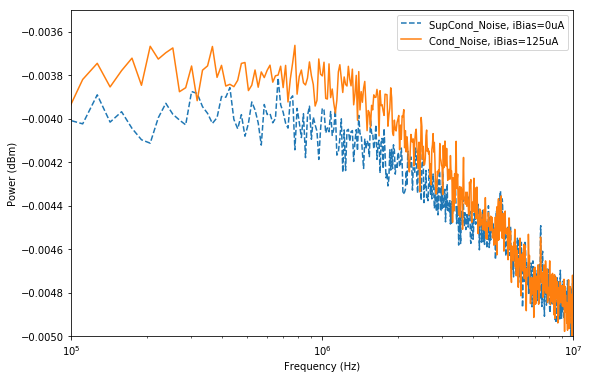

In [26]:
plt.figure(figsize=(9,6))
plt.plot(*density_spectrum(SupCond_Noise), label='SupCond_Noise, iBias=0uA',linestyle='--')
plt.plot(*density_spectrum(Cond_Noise), label='Cond_Noise, iBias=125uA')
plt.semilogx()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dBm)')
plt.ylim(-0.005,-0.0035)
plt.xlim(100e3,1e7) #R&S FSH8 only operates 100kHz onwards
plt.legend()
plt.tight_layout
plt.savefig('superconducting_vs_conducting_noise.pdf')

## IV Curve of SQUID 1

## Bandwidth Comparison of TES 5, SQUID 1, with different feedback resistances